In [1]:
# 提示语：数据科学工作常用的import语句
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import titanic_utils

plt.rcParams['font.family'] = 'Arial Unicode MS'  # or another font that supports your characters
sns.set(font='Arial Unicode MS')  # Apply the font to Seaborn

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# 提示语：读取训练数据和测试数据（分别在data/train.csv和data/test.csv），并分别存到X_train, X_test, y_train中
X_train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')
y_train = X_train['Survived']
X_train.drop('Survived', axis=1, inplace=True)

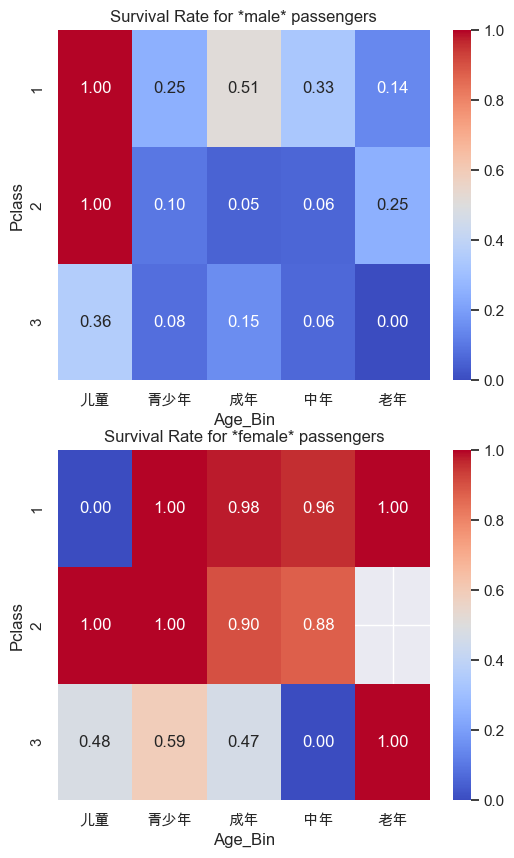

In [3]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data['Age_Bin'] = pd.cut(training_data['Age'], bins=[0, 12, 19, 39, 59, np.inf], labels=['儿童', '青少年', '成年', '中年', '老年'])

# 提示语：对于每个性别，画出分舱位等级分年龄段的幸存率，画一个热力图。
fix, axes = plt.subplots(2, 1, figsize=(6, 10))
for i, gender in enumerate(['male', 'female']):
    filtered_data = training_data[training_data['Sex'] == gender]
    pivot_table = filtered_data.pivot_table(index='Pclass', columns='Age_Bin', values='Survived', aggfunc='mean', observed=True)

    axes[i].set_title(f'Survival Rate for *{gender}* passengers')
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[i])

In [4]:
# 提示语：实现一个模型，根据性别、年龄、舱位等级来预测是否幸存，叫GenderAgePclassModel。具体来说，如果乘客是女性，则看舱位等级来决定是否幸存，舱位等级为特等舱或者二等舱则判断为幸存，三等舱则判断为遇难。如果乘客是男性，则看年龄段和舱位等级，如果是儿童且头等舱或二等舱，则判断为幸存，否则判断为遇难。
class GenderAgePclassModel(BaseEstimator):
    def fit(self, X, y):
        pass

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            if row['Sex'] == 'female':
                if row['Pclass'] in [1, 2]:
                    predictions.append(1)  # Survival
                else:
                    predictions.append(0)  # Dead
            else:
                if row['Age'] <= 12 and row['Pclass'] in [1, 2]:
                    predictions.append(1)  # Survival
                else:
                    predictions.append(0)  # Dead
        return predictions

model = GenderAgePclassModel()
titanic_utils.print_model_accuracy(model, X_train, y_train, X_test)

训练数据集准确率: 80.02%
测试数据集准确率: 78.23%


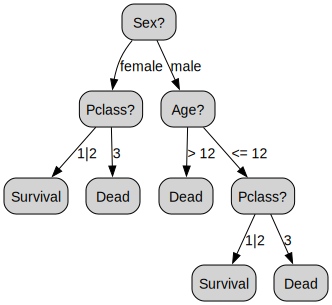

In [13]:
# 提示语：把上面GenderAgePclassModel的predict()函数中的决策树画出来。先定义一个decision_tree字符串，然后用graphviz.Source()和render()函数画出来。

decision_tree = '''
digraph Tree {
node [shape=box, style="filled, rounded", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="Sex?"];
1 [label="Pclass?"];
0 -> 1 [label="female"];
2 [label="Survival"];
1 -> 2 [label="1|2"];
3 [label="Dead"];
1 -> 3 [label="3"];
4 [label="Age?"];
0 -> 4 [label="male"];
5 [label="Dead"];
4 -> 5 [label="> 12"];
6 [label="Pclass?"];
4 -> 6 [label="<= 12"];
7 [label="Survival"];
6 -> 7 [label="1|2"];
8 [label="Dead"];
6 -> 8 [label="3"];
}
'''

graph = graphviz.Source(decision_tree)
graph.render(filename="decision_tree", format='png')
graph

In [5]:
# 提示语：从combined_df中，提取并转化以下特征，性别、年龄、舱位等级、同乘的兄弟姐妹或配偶数、同乘的父母或子女数量、票价、登船港口，为后续训练决策树模型做准备。
combined_df = pd.concat([X_train, X_test], axis=0)

selected_columns = ['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']
combined_df = combined_df[selected_columns]
combined_df['Sex'] = combined_df['Sex'].map({'male': 0, 'female': 1})
combined_df['Embarked'] = combined_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

X_train_selected = combined_df[:len(X_train)]
X_test_selected = combined_df[len(X_train):]

In [6]:
# 提示语：基于上面的特征，训练一个决策树模型，然后用titanic_utils.print_model_accuracy()函数来评估模型的准确率。
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train_selected, y_train)
titanic_utils.print_model_accuracy(model, X_train_selected, y_train, X_test_selected)

训练数据集准确率: 86.08%
测试数据集准确率: 75.84%


In [7]:
# 提示语：上面的决策树模型看起来过拟合了，训练数据集准确率达到98%。我们来看看交叉验证的准确率。
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(model, X_train_selected, y_train, cv=4)
mean_accuracy = scores.mean()
print(f"交叉验证准确率：{mean_accuracy:.2%}")

交叉验证准确率：80.02%


In [14]:
""" 提示语：
用wandb的Sweep功能来调参，搜索max_depth, min_samples_split, min_samples_leaf这三个参数的最佳值。由以下几个部分组成：

1. 实现一个train()函数，wandb对每一组参数调用这个函数，进行训练和记录结果。train()函数的实现如下：
1.1. 初始化wandb，并从wandb.config获取相关参数。
1.2. 训练一个决策树模型，使用上面提到的特征，和获取的参数。
1.3. 计算模型的训练准确率、交叉验证准确率、F1 Score、ROC AUC、测试准确率等指标。
1.4. 把这些指标记录到wandb。

2. 定义一个sweep_config字典，包含method, metric, parameters等字段。具体如下：
2.1. method: 使用bayes方法。
2.2. metric: 优化的目标是最大化交叉验证准确率。
2.3. parameters: 三个参数max_depth, min_samples_split, min_samples_leaf的搜索范围。

3. 创建wandb Sweep，并调用wandb.agent()进行调参，最多尝试50次。
"""

import wandb
import wandb.agents
import wandb.sklearn
import wandb.wandb_agent

def train():
    wandb.init()

    # Get parameters from wandb.config
    max_depth = wandb.config.max_depth
    min_samples_split = wandb.config.min_samples_split
    min_samples_leaf = wandb.config.min_samples_leaf

    # Train a decision tree model with the specified parameters
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train_selected, y_train)
    model_params = model.get_params()
    y_pred = model.predict(X_train_selected)
    y_probas = model.predict_proba(X_train_selected)

    # Plot various performance matrics
    labels = [0, 1]
    wandb.sklearn.plot_learning_curve(model, X_train_selected, y_train)
    wandb.sklearn.plot_roc(y_train, y_probas, labels)
    wandb.sklearn.plot_precision_recall(y_train, y_probas, labels)
    wandb.sklearn.plot_confusion_matrix(y_train, y_pred, labels)
    wandb.sklearn.plot_feature_importances(model, X_train_selected.columns)

    # Evaluate the model accuracy
    train_accuracy = model.score(X_train_selected, y_train)
    cv_acuracy = cross_val_score(model, X_train_selected, y_train, cv=4).mean()
    f1_score_result = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_probas[:, 1])
    test_accuracy = titanic_utils.evaluate_test_accuracy(model, X_test_selected)

    # Log the results to wandb
    wandb.log({
        "Train Accuracy": train_accuracy,
        "Cross Validation Accuracy": cv_acuracy,
        "F1 Score": f1_score_result,
        "ROC AUC": roc_auc,
        "Test Accuracy": test_accuracy,
        "Model Parameters": model_params,
    })
    wandb.finish()


# 提示语：用wandb sweep调参，搜索max_depth, min_samples_split, min_samples_leaf这三个参数的最佳值。
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'Cross Validation Accuracy', 'goal': 'maximize'},
    'parameters': {
        "max_depth": {"min": 1, "max": 10},
        "min_samples_split": {"min": 2, "max": 10},
        "min_samples_leaf": {"min": 1, "max": 10}
    },
}

sweep_id = wandb.sweep(sweep_config, project='kaggle-titanic')
# sweep_id = "wxlh1jtz"
wandb.agent(sweep_id, train, count=50)
wandb.finish()

ModuleNotFoundError: No module named 'wandb.agents'

In [16]:
# 提示语：通过Sweep调参，最佳参数是max_depth=4, min_samples_leaf=6, min_samples_split=4。用这些参数训练一个决策树模型，并评估准确率。
model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=4, random_state=0)
model.fit(X_train_selected, y_train)
titanic_utils.print_model_accuracy(model, X_train_selected, y_train, X_test_selected)

训练数据集准确率: 79.57%
测试数据集准确率: 76.08%
